# Enviroment Setup

In [1]:
!pip install opencv-python-headless
import os
import cv2
from tqdm import tqdm
from ipywidgets import interact, widgets
from IPython.display import display, HTML
from base64 import b64encode
from moviepy.editor import VideoFileClip
import subprocess


!git clone https://github.com/YUyou0/ict3104-team14-2023.git

!sudo apt-get install python3.8
!sudo apt-get install python3.8-distutils
!sudo apt-get update
!python --version
!apt-get update
!apt install software-properties-common
!sudo dpkg --remove --force-remove-reinstreq python3-pip python3-setuptools python3-wheel
!apt-get install python3-pip

!cd /content/ict3104-team14-2023
!export PYTHONPATH=/content/FollowYourPose:$PYTHONPATH
# %pip install -r requirements.txt
!python3.8 -m pip install -q -U --pre triton
!apt update
!python3.8 -m pip install -q diffusers==0.11.1 torch==1.13.1 transformers==4.26.0 bitsandbytes==0.35.4 \
imageio-ffmpeg xformers==0.0.16  --extra-index-url https://download.pytorch.org/whl/cu113

%cd /content/ict3104-team14-2023/
!python3.8 -m pip install -r requirements.txt

Cloning into 'ict3104-team14-2023'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 110 (delta 1), reused 6 (delta 1), pack-reused 104
Receiving objects: 100% (110/110), 66.26 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib mailcap mime-support
  python3.8-minimal
Suggested packages:
  python3.8-venv binfmt-support
The following NEW packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib mailcap mime-support python3.8
  python3.8-minimal
0 upgraded, 6 newly installed, 0 to remove and 18 not upgraded.
Need to get 5,098 kB of archives.
After this operation, 18.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3

In [2]:
%mkdir checkpoints
!git lfs install
!git clone https://huggingface.co/YueMafighting/FollowYourPose_v1
%mv /content/ict3104-team14-2023/FollowYourPose_v1/* /content/ict3104-team14-2023/checkpoints/
%rm -rf FollowYourPose_v1

!sudo apt-get install python3.8
!sudo apt-get install python3.8-distutils

Updated git hooks.
Git LFS initialized.
Cloning into 'FollowYourPose_v1'...
remote: Enumerating objects: 42, done.
remote: Total 42 (delta 0), reused 0 (delta 0), pack-reused 42
Unpacking objects: 100% (42/42), 584.62 KiB | 9.43 MiB/s, done.
Filtering content: 100% (9/9), 9.75 GiB | 52.16 MiB/s, done.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.8 is already the newest version (3.8.18-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.8-distutils is already the newest version (3.8.18-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


# Select a pretrained model that you want to use for testing

In [3]:
import os
import ipywidgets as widgets
from IPython.display import display

# Define the path to the folder containing the files
folder_path = '/content/ict3104-team14-2023/configs'  # Replace with the actual folder path

# List files in the folder
model_list = os.listdir(folder_path)
model_list.insert(0,"")  # Insert "" at the start of the list

# Create a dropdown widget
model_dropdown = widgets.Dropdown(
    options=model_list,
    description='Select a file:'
)

# Display the dropdown widget
display(model_dropdown)

Dropdown(description='Select a file:', options=('', 'pose_sample.yaml'), value='')

# Run this cell below to confirm your selected pretrained model to be used for testing

In [4]:
# Get the selected file name from the dropdown
selected_model = model_dropdown.value

# Check if the selected option is valid
if selected_model == "":
    raise ValueError("Invalid option selected. Please choose from the provided list.")

# Now 'selected_file' contains the selected file name as a string
print(f"Selected model: {selected_model}")

Selected model: pose_sample.yaml


# Input validation prompts

In [5]:
# Create a text input widget for the first validation prompt
text_input = widgets.Text(
    value='',  # Default value (you can set a default value if needed)
    placeholder='Enter the validation prompt',  # Placeholder text
    description='Text Input:',  # Label for the input field
)

# Create a submit button for the first validation prompt
submit_button = widgets.Button(
    description='Submit',  # Label for the button
)

# Create a variable to store the first user's input
user_input = ''

# Define a function to update the user_input variable when the first submit button is clicked
def on_submit_button_click(b):
    global user_input
    user_input = text_input.value
    if user_input == "":
      print("Validation prompt is empty!")
    else:
      print(f"Validation prompt 1 has been submitted : {user_input} ")

# Attach the click event handler to the first submit button
submit_button.on_click(on_submit_button_click)


# Display the widgets
display(text_input, submit_button)

Text(value='', description='Text Input:', placeholder='Enter the validation prompt')

Button(description='Submit', style=ButtonStyle())

Validation prompt 1 has been submitted : spiderman on the beach 


# Confirm validation prompts

In [6]:
print(f"Validation prompt : {user_input}")
# Check if the selected option is valid
if (user_input == ""):
  raise ValueError("You have not written a validation prompt.")

# Split the string into words using whitespace as the delimiter
words = user_input.split()

# Count the number of words
word_count = len(words)
print(word_count)

Validation prompt : spiderman on the beach
4


# Update validation prompt to configuration file

In [7]:
!pip install pyyaml
import yaml

config_file_path = '/content/ict3104-team14-2023/configs/pose_sample.yaml'
line_number = 6                   # Replace with the line number you want to update (zero-based index)

# Load the YAML file as a list of lines
with open(config_file_path, 'r') as file:
    lines = file.readlines()

if user_input != "":
  # Get user input for the new value for first validation prompt
  new_value1 = f"  - \"{user_input}\" "
  # Update the specific line in the list with the new value
  lines[line_number] = f"{new_value1}\n"  # Add a newline character to match the YAML format
  # Write the updated list of lines back to the YAML file
  with open(config_file_path, 'w') as file:
      file.writelines(lines)

  # Load the YAML file as a list of lines
  with open(config_file_path, 'r') as file:
      lines = file.readlines()

# Select pose

In [8]:
# Define the path to the folder containing the files
folder_path = '/content/ict3104-team14-2023/pose_example'  # Replace with the actual folder path

# List files in the folder
pose_list = os.listdir(folder_path)
pose_list.insert(0,"")  # Insert "" at the start of the list

# Create a dropdown widget
pose_dropdown = widgets.Dropdown(
    options=pose_list,
    description='Select a file:'
)

# Display the dropdown widget
display(pose_dropdown)

Dropdown(description='Select a file:', options=('', 'vis_ikun_pose1.MOV', 'vis_ikun_pose2.mov'), value='')

# Confirm your selected pose

In [9]:
# Get the selected file name from the dropdown
selected_pose = pose_dropdown.value

# Check if the selected option is valid
if selected_pose == "":
    raise ValueError("Invalid option selected. Please choose from the provided list.")

# Now 'selected_file' contains the selected file name as a string
print(f"Selected Pose: {selected_pose}")

Selected Pose: vis_ikun_pose2.mov


# Set Inference Step

In [10]:
# Function to handle the button click event
def on_submit_button_click(b):
    global user_input_inferenceStep
    user_input_inferenceStep= text_input.value
    # Check if the input is a valid whole number (integer)
    if  user_input_inferenceStep.isdigit():
        print(f"Inference step accepted: { user_input_inferenceStep}")
    else:
        print("Invalid input. Please enter a whole number (no decimals).")

# Create a text input widget
text_input = widgets.Text(
    placeholder='Set Inference Step',
    description='',
)

# Create a submit button
submit_button = widgets.Button(
    description='Submit',
)
submit_button.on_click(on_submit_button_click)

# Display the input field and submit button
display(text_input)
display(submit_button)

Text(value='', placeholder='Set Inference Step')

Button(description='Submit', style=ButtonStyle())

Inference step accepted: 1
Inference step accepted: 10


# Update Inference step to system

In [11]:
print(f"Inference step : {user_input_inferenceStep}")

config_file_path = '/content/ict3104-team14-2023/configs/pose_sample.yaml'
line_number = 13                   # Replace with the line number you want to update (zero-based index)

# Load the YAML file as a list of lines
with open(config_file_path, 'r') as file:
    lines = file.readlines()

if user_input != "":
  # Get user input for the new value for first validation prompt
  new_value = f"  num_inference_steps: {user_input_inferenceStep}"
  # Update the specific line in the list with the new value
  lines[line_number] = f"{new_value}\n"  # Add a newline character to match the YAML format
  # Write the updated list of lines back to the YAML file
  with open(config_file_path, 'w') as file:
      file.writelines(lines)

  # Load the YAML file as a list of lines
  with open(config_file_path, 'r') as file:
      lines = file.readlines()


Inference step : 10


#  File verification and load execution command

In [12]:
if selected_model != "":
  print("Pretrained model loaded successful")
  print(selected_model)

print("\n")

if selected_pose != "":
   print("Stickman pose loaded successful")
   print(selected_pose)

print("\n")

if user_input != "":
   print("Validation prompt(s) loaded successful")
   print(user_input)

print("\n")

if selected_model == "":
    raise ValueError("Invalid option selected. Please choose from the provided list.")

# Check if the selected option is valid
if selected_pose == "":
    raise ValueError("Invalid option selected. Please choose from the provided list.")

# Check if the selected option is valid
if user_input == "":
  raise ValueError("You have not written a validation prompt.")


command = f"TORCH_DISTRIBUTED_DEBUG=DETAIL accelerate launch txt2video.py --config=\"configs/{selected_model}\" --skeleton_path=\"./pose_example/{selected_pose}\""
print(command)

Pretrained model loaded successful
pose_sample.yaml


Stickman pose loaded successful
vis_ikun_pose2.mov


Validation prompt(s) loaded successful
spiderman on the beach


TORCH_DISTRIBUTED_DEBUG=DETAIL accelerate launch txt2video.py --config="configs/pose_sample.yaml" --skeleton_path="./pose_example/vis_ikun_pose2.mov"


#  Start testing process

In [14]:
import time
import csv
%cd /content/ict3104-team14-2023
!pwd

trimmed_selected_model = selected_model[:-5]
# Print the trimmed string



# Specify the folder path you want to create
folder_path = f"/content/ict3104-team14-2023/testing/{trimmed_selected_model}"

# Check if the folder exists
if not os.path.exists(folder_path):
    # If it doesn't exist, create it
    os.mkdir(folder_path)
    print(f"Folder '{folder_path}' created successfully.")
else:
    print(f"Folder '{folder_path}' already exists, so it was not created.")

start_time = time.time()
!{command}
end_time = time.time()

response_time = end_time - start_time
formatted_response_time = "{:.2f}".format(response_time)
print(f"Model used: {trimmed_selected_model}")
print(f"Response time : {formatted_response_time} seconds")
print(f"Inference step : {user_input_inferenceStep}")
print(f"Validation prompt : {user_input}")
print(f"Word count in validation prompt : {word_count}")

# Specify the CSV file path you want to create
csv_file_path = f"/content/ict3104-team14-2023/testing/{trimmed_selected_model}/{trimmed_selected_model}-responseTime.csv"

# Check if the CSV file exists
if not os.path.exists(csv_file_path):
    # If it doesn't exist, create it and write headers (if needed)
    with open(csv_file_path, 'w', newline='') as csvfile:
        # You can write headers here if needed
        # For example:
        fieldnames = ['inference steps', 'response time',]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    print(f"CSV file '{csv_file_path}' created successfully.")
else:
    print(f"CSV file '{csv_file_path}' already exists, so it was not created.")

# Create or open the CSV file in append mode
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)

    # Write the variables into a CSV row
    writer.writerow([user_input_inferenceStep,formatted_response_time])

print(f"Variables saved to '{csv_file_path}' successfully.")


/content/ict3104-team14-2023
/content/ict3104-team14-2023
Folder '/content/ict3104-team14-2023/testing/pose_sample' created successfully.
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: module 'triton.language' has no attribute 'constexpr'
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

# View the scatterplot of the response time

/content/ict3104-team14-2023/testing/pose_sample


Text(0.5, 1.0, 'Scatter Plot Of Response Time Using pose_sample.yaml')

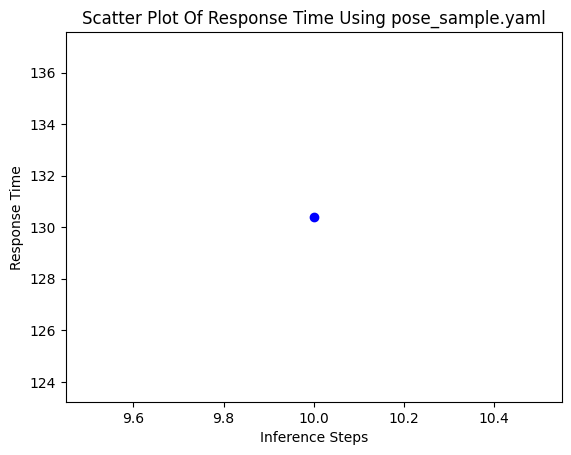

In [15]:
%cd /content/ict3104-team14-2023/testing/pose_sample

import pandas as pd
import random
import matplotlib.pyplot as plt

df = pd.read_csv("pose_sample-responseTime.csv")

x = df["inference steps"]
y = df["response time"]

plt.scatter(x, y, label='Scatter Plot', color='blue', marker='o')

plt.xlabel('Inference Steps')
plt.ylabel('Response Time')
plt.title(f'Scatter Plot Of Response Time Using {selected_model}')

# Select a directory for SSIM calculation

In [46]:
import os
import ipywidgets as widgets
from IPython.display import display

%cd /content/ict3104-team14-2023/checkpoints/inference


# Create a dropdown widget for selecting a directory
directory_dropdown = widgets.Dropdown(
    options=[''] + sorted(os.listdir()),
    description='Select a directory:',
    layout={'width': '400px'}
)

# Create a dropdown widget for selecting a file
file_dropdown = widgets.Dropdown(
    options=[''],
    description='Select a file:',
    layout={'width': '400px'}
)

# Function to update the file dropdown based on the selected directory
def update_file_dropdown(change):
    selected_directory = change.new
    if selected_directory:
        files_in_directory = sorted(os.listdir(selected_directory))
        file_dropdown.options = [''] + files_in_directory
    else:
        file_dropdown.options = ['']

# Link the directory dropdown to the file dropdown
directory_dropdown.observe(update_file_dropdown, 'value')

# Display the widgets
display(directory_dropdown, file_dropdown)

# Create a button to store the selected file name
store_button = widgets.Button(description="Confirm Gif selection")

# Global variable to store the selected file name
selected_file_name = None

# Function to store the selected file name
def store_selection(_):
    global selected_gif
    selected_file = file_dropdown.value
    if selected_file:
        selected_gif = selected_file
        print(f"Selected File Name Stored: {selected_gif}")
    else:
        print("Please select a file before storing.")

# Link the button to the store_selection function
store_button.on_click(store_selection)

# Display the store button
display(store_button)

/content/ict3104-team14-2023/checkpoints/inference


Dropdown(description='Select a directory:', layout=Layout(width='400px'), options=('', 'sample-1000-33-2023-10…

Dropdown(description='Select a file:', layout=Layout(width='400px'), options=('',), value='')

Button(description='Confirm Gif selection', style=ButtonStyle())

Selected File Name Stored: spiderman on the beach.gif


In [43]:
print(selected_directory)

sample-1000-33-2023-10-10 15:53:42.821126


# Calculate SSIM

In [47]:
import cv2
from skimage import img_as_ubyte
from skimage.metrics import structural_similarity as ssim

# Load the GIF as a video
gif_path = f"/content/ict3104-team14-2023/checkpoints/inference/{selected_directory}/{selected_gif}"
cap = cv2.VideoCapture(gif_path)

# Initialize variables to store SSIM values
previous_frame = None
ssim_values = []

# Process each frame in the GIF
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM
    if previous_frame is not None:
        ssim_score = ssim(previous_frame, frame_gray, full=True)[0]
        ssim_values.append(ssim_score)

    previous_frame = frame_gray

# Close the video capture
cap.release()

# Calculate the average SSIM score
average_ssim = sum(ssim_values) / len(ssim_values)

print("Average SSIM:", average_ssim)

Average SSIM: 0.3212460533905808


# Select a dataset to be used for the testing

In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display

# Function to list file names in a folder and store their paths in an array
def list_file_names_and_paths(folder):
    global file_paths
    folder_path = os.path.join('/content/ict3104-team14-2023/input_videos', folder)
    if os.path.isdir(folder_path):
        file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
        file_names = [os.path.basename(file) for file in file_paths]
        print(f"List of file names in '{folder}':")
        for file_name in file_names:
            print(file_name)
    else:
        print(f"'{folder}' is not a valid folder.")

# Create a dropdown widget with an empty default option
folder_dropdown = widgets.Dropdown(
    options=[''] + os.listdir('/content/ict3104-team14-2023/input_videos'),  # Include an empty option
    description='Select a Folder:',
)

# Initialize the file_paths array
file_paths = []

# Define an event handler for the dropdown
def on_dropdown_change(change):
    selected_folder = change.new
    list_file_names_and_paths(selected_folder)

# Attach the event handler to the dropdown
folder_dropdown.observe(on_dropdown_change, names='value')

# Display the dropdown widget
display(folder_dropdown)

Dropdown(description='Select a Folder:', options=('', 'charades'), value='')

List of file names in 'charades':
52CKM.mp4
3LMTS.mp4
5D3X6.mp4
5O0YS.mp4
3JJ7C.mp4
0RJKT.mp4
4GLAP.mp4
3IPI3.mp4
5EFQ7.mp4
8ASRQ.mp4
2E8GU.mp4
